In [1]:
import json
import os
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset
from shutil import rmtree as shutil_rmtree

F:\anaconda3\envs\p39_v2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
class CustomDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_seq_len=768):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.data = self.load_data(file_path)

    def load_data(self, file_path):
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        prompt = entry["prompt"]
        completion = entry["completion"]

        # Combine prompt and completion into a single input sequence
        input_text = f"{prompt} {self.tokenizer.sep_token} {completion}"

        # Tokenize and truncate input sequence
        input_ids = self.tokenizer.encode(input_text, max_length=self.max_seq_len, truncation=True)

        return torch.tensor(input_ids)

In [4]:
def prepare_dataset(dataset_name, file_path, tokenizer):
    # Check if the dataset file already exists
    if not os.path.exists(file_path):
        # Load the dataset from Hugging Face datasets library
        dataset = load_dataset(dataset_name)

        # Save the dataset to a file for future use
        with open(file_path, 'w') as file:
            json.dump(dataset, file)
    else:
        # Load the dataset from the file
        with open(file_path, 'r') as file:
            dataset = json.load(file)

    # Create a CustomDataset from the loaded dataset
    custom_dataset = CustomDataset(file_path, tokenizer)

    # Split the dataset into training, validation, and test sets
    num_samples = len(custom_dataset)
    train_split = int(0.8 * num_samples)
    val_split = int(0.1 * num_samples)
    
    train_dataset = Subset(custom_dataset, list(range(train_split)))
    val_dataset = Subset(custom_dataset, list(range(train_split, train_split + val_split)))
    test_dataset = Subset(custom_dataset, list(range(train_split + val_split, num_samples)))

    return train_dataset, val_dataset, test_dataset

In [5]:
#Accumulated batch size (since GPT2 is so big)
def pack_tensor(new_tensor, packed_tensor, max_seq_len):
    if packed_tensor is None:
        return new_tensor, True, None
    if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
        return packed_tensor, False, new_tensor
    else:
        packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
        return packed_tensor, True, None

In [6]:
def train(
    train_dataset, val_dataset, model, tokenizer,
    batch_size=16, epochs=5, lr=2e-5,
    max_seq_len=400, warmup_steps=200,
    gpt2_type="gpt2", output_dir="model_checkpoints", output_prefix="checkpoint",
    save_checkpoints=True,
):
    device = torch.device("cuda")
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
    )

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    best_val_loss = float('inf')

    model.eval()
    # Validation loss
    val_loss = 0
    with torch.no_grad():
        for val_entry in tqdm(val_dataloader):
            val_input_tensor = val_entry.to(device)
            val_outputs = model(val_input_tensor, labels=val_input_tensor)
            val_loss += val_outputs[0].item()
    val_loss /= len(val_dataloader)
    print(f"Validation Loss: {val_loss}")
    val_losses = [val_loss]

    # Training loss
    train_loss = 0
    with torch.no_grad():
        for train_entry in tqdm(train_dataloader):
            train_input_tensor = train_entry.to(device)
            train_outputs = model(train_input_tensor, labels=train_input_tensor)
            train_loss += train_outputs[0].item()
    train_loss /= len(train_dataloader)
    print(f"Training Loss: {train_loss}")
    train_losses = [train_loss]
    
    model.train()

    if save_checkpoints:
        save_path = os.path.join(output_dir, f"{output_prefix}_initial")
        if os.path.exists(save_path):
            shutil_rmtree(save_path)
        model.save_pretrained(save_path)
        print(f"Saved initial")
        
    # Training loop
    for epoch in range(1, epochs+1):
        print(f"Training epoch {epoch}")

        # pdb.set_trace()

        # Training step
        for idx, entry in tqdm(enumerate(train_dataloader)):
            input_tensor, carry_on, remainder = pack_tensor(entry, None, max_seq_len)

            # if carry_on and idx != len(train_dataloader) - 1:
            #     continue

            input_tensor = input_tensor.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            loss = outputs[0]
            loss.backward()

            if (idx + 1) % batch_size == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                model.zero_grad()

        
        model.eval()
        # Validation loss
        val_loss = 0
        with torch.no_grad():
            for val_entry in tqdm(val_dataloader):
                val_input_tensor = val_entry.to(device)
                val_outputs = model(val_input_tensor, labels=val_input_tensor)
                val_loss += val_outputs[0].item()
        val_loss /= len(val_dataloader)
        print(f"Validation Loss: {val_loss}")
        val_losses.append(val_loss)

        # Training loss
        train_loss = 0
        with torch.no_grad():
            for train_entry in tqdm(train_dataloader):
                train_input_tensor = train_entry.to(device)
                train_outputs = model(train_input_tensor, labels=train_input_tensor)
                train_loss += train_outputs[0].item()
        train_loss /= len(train_dataloader)
        print(f"Training Loss: {train_loss}")
        train_losses.append(train_loss)
        
        model.train()

        # Save the model if it's the best so far
        if save_checkpoints and val_loss < best_val_loss:
            best_val_loss = val_loss
            save_path = os.path.join(output_dir, f"{output_prefix}_best")
            if os.path.exists(save_path):
                shutil_rmtree(save_path)
            model.save_pretrained(save_path)
            print(f"Saved best at Epoch {epoch}")

    if save_checkpoints:
        save_path = os.path.join(output_dir, f"{output_prefix}_final")
        if os.path.exists(save_path):
            shutil_rmtree(save_path)
        model.save_pretrained(save_path)
        print(f"Saved final at Epoch {epoch}")

    return model, val_losses, train_losses

In [7]:
def evaluate(model, dataloader, device, output_file, tokenizer):
    model.eval()
    total_loss = 0
    detokenized_outputs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_tensor = batch.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            total_loss += outputs.loss.item()
            
            # Detach the logits before using them for decoding
            # logits = outputs.logits.detach()
            # detokenized_output = tokenizer.decode(torch.argmax(logits, dim=-1).tolist(), skip_special_tokens=True)
            # detokenized_outputs.append(detokenized_output)
            # output_file.write(detokenized_output + '\n')

    avg_loss = total_loss / len(dataloader)
    return avg_loss, detokenized_outputs

In [8]:
def collate_fn(batch):
    return torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0)

### Fine-tuning

In [9]:
# Define your GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Specify the dataset name and file path
dataset_name = "propmts_and_completions"
file_path = 'prompts.json'
output_file = 'detokenized_outputs.txt'

# Prepare the dataset
train_dataset, val_dataset, test_dataset = prepare_dataset(dataset_name, file_path, tokenizer)

In [10]:
seed = 182
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Train the model
trained_model, val_losses, train_losses = train(
    train_dataset, val_dataset, model, tokenizer, batch_size=8, epochs=100, lr=1e-3)

F:\anaconda3\envs\p39_v2\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  9.89it/s]


Validation Loss: 2.962575078010559


100%|██████████| 11/11 [00:00<00:00, 18.43it/s]


Training Loss: 2.557798754085194
Saved initial
Training epoch 1


11it [00:01,  6.63it/s]
100%|██████████| 2/2 [00:00<00:00, 35.31it/s]


Validation Loss: 2.962575078010559


100%|██████████| 11/11 [00:00<00:00, 22.00it/s]


Training Loss: 2.6173171780326148
Saved best at Epoch 1
Training epoch 2


11it [00:01,  7.58it/s]
100%|██████████| 2/2 [00:00<00:00, 25.28it/s]


Validation Loss: 2.9367740154266357


100%|██████████| 11/11 [00:00<00:00, 21.21it/s]


Training Loss: 2.5686407522721724
Saved best at Epoch 2
Training epoch 3


11it [00:01,  6.90it/s]
100%|██████████| 2/2 [00:00<00:00, 12.34it/s]


Validation Loss: 2.8959062099456787


100%|██████████| 11/11 [00:00<00:00, 22.75it/s]


Training Loss: 2.4908929521387275
Saved best at Epoch 3
Training epoch 4


11it [00:01,  7.73it/s]
100%|██████████| 2/2 [00:00<00:00, 33.57it/s]


Validation Loss: 2.8483572006225586


100%|██████████| 11/11 [00:00<00:00, 22.48it/s]


Training Loss: 2.408349709077315
Saved best at Epoch 4
Training epoch 5


11it [00:01,  7.73it/s]
100%|██████████| 2/2 [00:00<00:00, 16.13it/s]


Validation Loss: 2.797918677330017


100%|██████████| 11/11 [00:00<00:00, 23.27it/s]


Training Loss: 2.4959763938730415
Saved best at Epoch 5
Training epoch 6


11it [00:01,  7.89it/s]
100%|██████████| 2/2 [00:00<00:00, 34.13it/s]


Validation Loss: 2.7465391159057617


100%|██████████| 11/11 [00:00<00:00, 22.85it/s]


Training Loss: 2.3238123546947134
Saved best at Epoch 6
Training epoch 7


11it [00:01,  7.29it/s]
100%|██████████| 2/2 [00:00<00:00, 36.57it/s]


Validation Loss: 2.6907747983932495


100%|██████████| 11/11 [00:00<00:00, 23.51it/s]


Training Loss: 2.413029345599088
Saved best at Epoch 7
Training epoch 8


11it [00:01,  6.75it/s]
100%|██████████| 2/2 [00:00<00:00, 32.51it/s]


Validation Loss: 2.633060097694397


100%|██████████| 11/11 [00:00<00:00, 22.39it/s]


Training Loss: 2.2167224017056553
Saved best at Epoch 8
Training epoch 9


11it [00:01,  7.47it/s]
100%|██████████| 2/2 [00:00<00:00, 37.24it/s]


Validation Loss: 2.5806446075439453


100%|██████████| 11/11 [00:00<00:00, 23.42it/s]


Training Loss: 2.1982766714963047
Saved best at Epoch 9
Training epoch 10


11it [00:01,  7.60it/s]
100%|██████████| 2/2 [00:00<00:00, 12.34it/s]


Validation Loss: 2.5379120111465454


100%|██████████| 11/11 [00:00<00:00, 22.66it/s]


Training Loss: 2.086293328892101
Saved best at Epoch 10
Training epoch 11


11it [00:01,  6.83it/s]
100%|██████████| 2/2 [00:00<00:00, 12.26it/s]


Validation Loss: 2.499908924102783


100%|██████████| 11/11 [00:00<00:00, 22.13it/s]


Training Loss: 2.0276330601085317
Saved best at Epoch 11
Training epoch 12


11it [00:02,  5.09it/s]
100%|██████████| 2/2 [00:00<00:00, 30.33it/s]


Validation Loss: 2.463735818862915


100%|██████████| 11/11 [00:00<00:00, 18.02it/s]


Training Loss: 1.9748769781806252
Saved best at Epoch 12
Training epoch 13


11it [00:01,  5.60it/s]
100%|██████████| 2/2 [00:00<00:00, 24.38it/s]


Validation Loss: 2.42929470539093


100%|██████████| 11/11 [00:00<00:00, 18.50it/s]


Training Loss: 2.0172082510861484
Saved best at Epoch 13
Training epoch 14


11it [00:01,  7.27it/s]
100%|██████████| 2/2 [00:00<00:00, 25.43it/s]


Validation Loss: 2.3944143056869507


100%|██████████| 11/11 [00:00<00:00, 18.26it/s]


Training Loss: 1.9025234634226018
Saved best at Epoch 14
Training epoch 15


11it [00:01,  6.07it/s]
100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


Validation Loss: 2.3616316318511963


100%|██████████| 11/11 [00:00<00:00, 18.57it/s]


Training Loss: 1.9130455580624668
Saved best at Epoch 15
Training epoch 16


11it [00:01,  6.06it/s]
100%|██████████| 2/2 [00:00<00:00, 27.12it/s]


Validation Loss: 2.3288482427597046


100%|██████████| 11/11 [00:00<00:00, 19.15it/s]


Training Loss: 1.888722831552679
Saved best at Epoch 16
Training epoch 17


11it [00:01,  6.00it/s]
100%|██████████| 2/2 [00:00<00:00, 14.68it/s]


Validation Loss: 2.2976455688476562


100%|██████████| 11/11 [00:00<00:00, 18.03it/s]


Training Loss: 1.7653481635180386
Saved best at Epoch 17
Training epoch 18


11it [00:01,  6.02it/s]
100%|██████████| 2/2 [00:00<00:00, 14.42it/s]


Validation Loss: 2.26796817779541


100%|██████████| 11/11 [00:00<00:00, 16.67it/s]


Training Loss: 1.7085905400189487
Saved best at Epoch 18
Training epoch 19


11it [00:01,  5.87it/s]
100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


Validation Loss: 2.2492531538009644


100%|██████████| 11/11 [00:00<00:00, 18.83it/s]


Training Loss: 1.6862023635344072
Saved best at Epoch 19
Training epoch 20


11it [00:01,  5.97it/s]
100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


Validation Loss: 2.240926504135132


100%|██████████| 11/11 [00:00<00:00, 19.55it/s]


Training Loss: 1.6478350487622349
Saved best at Epoch 20
Training epoch 21


11it [00:01,  6.29it/s]
100%|██████████| 2/2 [00:00<00:00, 19.69it/s]


Validation Loss: 2.2327297925949097


100%|██████████| 11/11 [00:00<00:00, 18.08it/s]


Training Loss: 1.615646849979054
Saved best at Epoch 21
Training epoch 22


11it [00:01,  6.30it/s]
100%|██████████| 2/2 [00:00<00:00, 15.17it/s]


Validation Loss: 2.2204203605651855


100%|██████████| 11/11 [00:00<00:00, 18.18it/s]


Training Loss: 1.546177864074707
Saved best at Epoch 22
Training epoch 23


11it [00:01,  6.03it/s]
100%|██████████| 2/2 [00:00<00:00, 13.56it/s]


Validation Loss: 2.2104804515838623


100%|██████████| 11/11 [00:00<00:00, 18.22it/s]


Training Loss: 1.4818719083612615
Saved best at Epoch 23
Training epoch 24


11it [00:02,  5.48it/s]
100%|██████████| 2/2 [00:00<00:00, 28.84it/s]


Validation Loss: 2.2034270763397217


100%|██████████| 11/11 [00:00<00:00, 18.08it/s]


Training Loss: 1.4140059514479204
Saved best at Epoch 24
Training epoch 25


11it [00:01,  5.70it/s]
100%|██████████| 2/2 [00:00<00:00, 14.27it/s]


Validation Loss: 2.1990543603897095


100%|██████████| 11/11 [00:00<00:00, 18.74it/s]


Training Loss: 1.4050140164115212
Saved best at Epoch 25
Training epoch 26


11it [00:02,  4.94it/s]
100%|██████████| 2/2 [00:00<00:00, 34.69it/s]


Validation Loss: 2.198813319206238


100%|██████████| 11/11 [00:00<00:00, 20.70it/s]


Training Loss: 1.36506910757585
Saved best at Epoch 26
Training epoch 27


11it [00:01,  5.65it/s]
100%|██████████| 2/2 [00:00<00:00,  8.83it/s]


Validation Loss: 2.2022688388824463


100%|██████████| 11/11 [00:00<00:00, 21.05it/s]


Training Loss: 1.2588778409090908
Training epoch 28


11it [00:01,  6.21it/s]
100%|██████████| 2/2 [00:00<00:00, 32.51it/s]


Validation Loss: 2.2112828493118286


100%|██████████| 11/11 [00:00<00:00, 15.61it/s]


Training Loss: 1.254841381853277
Training epoch 29


11it [00:01,  6.43it/s]
100%|██████████| 2/2 [00:00<00:00, 13.00it/s]


Validation Loss: 2.2277954816818237


100%|██████████| 11/11 [00:00<00:00, 20.29it/s]


Training Loss: 1.1734774708747864
Training epoch 30


11it [00:01,  6.68it/s]
100%|██████████| 2/2 [00:00<00:00, 34.41it/s]


Validation Loss: 2.2472132444381714


100%|██████████| 11/11 [00:00<00:00, 19.95it/s]


Training Loss: 1.1075683507052334
Training epoch 31


11it [00:01,  6.72it/s]
100%|██████████| 2/2 [00:00<00:00, 25.43it/s]


Validation Loss: 2.261712431907654


100%|██████████| 11/11 [00:00<00:00, 20.09it/s]


Training Loss: 1.07714782519774
Training epoch 32


11it [00:01,  6.44it/s]
100%|██████████| 2/2 [00:00<00:00, 29.26it/s]


Validation Loss: 2.2739648818969727


100%|██████████| 11/11 [00:00<00:00, 20.50it/s]


Training Loss: 1.0417302467606284
Training epoch 33


11it [00:01,  6.37it/s]
100%|██████████| 2/2 [00:00<00:00, 10.89it/s]


Validation Loss: 2.285483479499817


100%|██████████| 11/11 [00:00<00:00, 20.20it/s]


Training Loss: 0.9675255905498158
Training epoch 34


11it [00:01,  6.53it/s]
100%|██████████| 2/2 [00:00<00:00, 32.51it/s]


Validation Loss: 2.2947202920913696


100%|██████████| 11/11 [00:00<00:00, 20.15it/s]


Training Loss: 0.9222033186392351
Training epoch 35


11it [00:01,  6.69it/s]
100%|██████████| 2/2 [00:00<00:00, 35.58it/s]


Validation Loss: 2.31184720993042


100%|██████████| 11/11 [00:00<00:00, 20.45it/s]


Training Loss: 0.892638320272619
Training epoch 36


11it [00:01,  6.56it/s]
100%|██████████| 2/2 [00:00<00:00, 37.24it/s]


Validation Loss: 2.336893081665039


100%|██████████| 11/11 [00:00<00:00, 21.11it/s]


Training Loss: 0.8438750776377592
Training epoch 37


11it [00:01,  6.60it/s]
100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


Validation Loss: 2.3704206943511963


100%|██████████| 11/11 [00:00<00:00, 19.69it/s]


Training Loss: 0.7939575585451993
Training epoch 38


11it [00:01,  6.49it/s]
100%|██████████| 2/2 [00:00<00:00, 16.19it/s]


Validation Loss: 2.4019863605499268


100%|██████████| 11/11 [00:00<00:00, 21.05it/s]


Training Loss: 0.7323526360771873
Training epoch 39


11it [00:01,  6.41it/s]
100%|██████████| 2/2 [00:00<00:00, 12.56it/s]


Validation Loss: 2.4343727827072144


100%|██████████| 11/11 [00:00<00:00, 21.27it/s]


Training Loss: 0.6913182627071034
Training epoch 40


11it [00:01,  6.69it/s]
100%|██████████| 2/2 [00:00<00:00, 16.72it/s]


Validation Loss: 2.461982011795044


100%|██████████| 11/11 [00:00<00:00, 19.79it/s]


Training Loss: 0.6373752518133684
Training epoch 41


11it [00:01,  6.50it/s]
100%|██████████| 2/2 [00:00<00:00, 13.98it/s]


Validation Loss: 2.4797139167785645


100%|██████████| 11/11 [00:00<00:00, 21.09it/s]


Training Loss: 0.5880114463242617
Training epoch 42


11it [00:01,  6.59it/s]
100%|██████████| 2/2 [00:00<00:00, 31.51it/s]


Validation Loss: 2.5108035802841187


100%|██████████| 11/11 [00:00<00:00, 20.93it/s]


Training Loss: 0.5334432639858939
Training epoch 43


11it [00:01,  6.33it/s]
100%|██████████| 2/2 [00:00<00:00, 12.15it/s]


Validation Loss: 2.5591752529144287


100%|██████████| 11/11 [00:00<00:00, 19.83it/s]


Training Loss: 0.4657885594801469
Training epoch 44


11it [00:01,  6.51it/s]
100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


Validation Loss: 2.6061244010925293


100%|██████████| 11/11 [00:00<00:00, 20.63it/s]


Training Loss: 0.4427782242948359
Training epoch 45


11it [00:01,  6.46it/s]
100%|██████████| 2/2 [00:00<00:00, 36.57it/s]


Validation Loss: 2.655678391456604


100%|██████████| 11/11 [00:00<00:00, 20.51it/s]


Training Loss: 0.39199069142341614
Training epoch 46


11it [00:01,  6.45it/s]
100%|██████████| 2/2 [00:00<00:00, 34.71it/s]


Validation Loss: 2.7067785263061523


100%|██████████| 11/11 [00:00<00:00, 20.18it/s]


Training Loss: 0.33501317555254156
Training epoch 47


11it [00:01,  6.39it/s]
100%|██████████| 2/2 [00:00<00:00, 15.51it/s]


Validation Loss: 2.764142632484436


100%|██████████| 11/11 [00:00<00:00, 20.47it/s]


Training Loss: 0.3095098828727549
Training epoch 48


11it [00:01,  6.59it/s]
100%|██████████| 2/2 [00:00<00:00, 10.80it/s]


Validation Loss: 2.812163472175598


100%|██████████| 11/11 [00:00<00:00, 19.49it/s]


Training Loss: 0.28579587963494385
Training epoch 49


11it [00:01,  6.65it/s]
100%|██████████| 2/2 [00:00<00:00, 14.27it/s]


Validation Loss: 2.827873468399048


100%|██████████| 11/11 [00:00<00:00, 19.77it/s]


Training Loss: 0.24563074789263986
Training epoch 50


11it [00:01,  6.68it/s]
100%|██████████| 2/2 [00:00<00:00, 14.89it/s]


Validation Loss: 2.8443026542663574


100%|██████████| 11/11 [00:00<00:00, 20.72it/s]


Training Loss: 0.21131393855268304
Training epoch 51


11it [00:01,  6.47it/s]
100%|██████████| 2/2 [00:00<00:00, 15.45it/s]


Validation Loss: 2.8793013095855713


100%|██████████| 11/11 [00:00<00:00, 19.47it/s]


Training Loss: 0.1859557100317695
Training epoch 52


11it [00:01,  5.90it/s]
100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


Validation Loss: 2.9254597425460815


100%|██████████| 11/11 [00:00<00:00, 12.70it/s]


Training Loss: 0.1686030707576058
Training epoch 53


11it [00:02,  5.42it/s]
100%|██████████| 2/2 [00:00<00:00, 31.51it/s]


Validation Loss: 2.9596738815307617


100%|██████████| 11/11 [00:00<00:00, 16.54it/s]


Training Loss: 0.1509050361134789
Training epoch 54


11it [00:01,  5.62it/s]
100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Validation Loss: 2.988434672355652


100%|██████████| 11/11 [00:00<00:00, 19.29it/s]


Training Loss: 0.1262135857885534
Training epoch 55


11it [00:01,  5.52it/s]
100%|██████████| 2/2 [00:00<00:00, 17.50it/s]


Validation Loss: 3.034447431564331


100%|██████████| 11/11 [00:00<00:00, 11.22it/s]


Training Loss: 0.11280020732771266
Training epoch 56


11it [00:01,  5.87it/s]
100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


Validation Loss: 3.079193115234375


100%|██████████| 11/11 [00:00<00:00, 18.15it/s]


Training Loss: 0.09914244440468875
Training epoch 57


11it [00:01,  5.80it/s]
100%|██████████| 2/2 [00:00<00:00, 31.03it/s]


Validation Loss: 3.097759962081909


100%|██████████| 11/11 [00:00<00:00, 18.08it/s]


Training Loss: 0.08691961521452124
Training epoch 58


11it [00:01,  5.94it/s]
100%|██████████| 2/2 [00:00<00:00, 14.12it/s]


Validation Loss: 3.1158922910690308


100%|██████████| 11/11 [00:00<00:00, 18.46it/s]


Training Loss: 0.07517583600499413
Training epoch 59


11it [00:01,  5.85it/s]
100%|██████████| 2/2 [00:00<00:00, 27.86it/s]


Validation Loss: 3.124776601791382


100%|██████████| 11/11 [00:00<00:00, 17.86it/s]


Training Loss: 0.06408802860162476
Training epoch 60


11it [00:01,  5.76it/s]
100%|██████████| 2/2 [00:00<00:00, 23.95it/s]


Validation Loss: 3.1419806480407715


100%|██████████| 11/11 [00:00<00:00, 17.54it/s]


Training Loss: 0.0597664009441029
Training epoch 61


11it [00:01,  6.13it/s]
100%|██████████| 2/2 [00:00<00:00, 27.67it/s]


Validation Loss: 3.172837734222412


100%|██████████| 11/11 [00:00<00:00, 17.08it/s]


Training Loss: 0.04917146841233427
Training epoch 62


11it [00:01,  5.75it/s]
100%|██████████| 2/2 [00:00<00:00, 32.00it/s]


Validation Loss: 3.2335115671157837


100%|██████████| 11/11 [00:00<00:00, 18.80it/s]


Training Loss: 0.048704858530651436
Training epoch 63


11it [00:01,  5.99it/s]
100%|██████████| 2/2 [00:00<00:00, 13.38it/s]


Validation Loss: 3.2729276418685913


100%|██████████| 11/11 [00:00<00:00, 17.43it/s]


Training Loss: 0.041315403174270286
Training epoch 64


11it [00:01,  5.91it/s]
100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


Validation Loss: 3.296868324279785


100%|██████████| 11/11 [00:00<00:00, 18.03it/s]


Training Loss: 0.03629240071908994
Training epoch 65


11it [00:01,  5.96it/s]
100%|██████████| 2/2 [00:00<00:00, 13.55it/s]


Validation Loss: 3.3146016597747803


100%|██████████| 11/11 [00:00<00:00, 17.85it/s]


Training Loss: 0.035294150256297806
Training epoch 66


11it [00:01,  7.64it/s]
100%|██████████| 2/2 [00:00<00:00, 29.26it/s]


Validation Loss: 3.3351279497146606


100%|██████████| 11/11 [00:00<00:00, 18.47it/s]


Training Loss: 0.03476896475661884
Training epoch 67


11it [00:01,  5.65it/s]
100%|██████████| 2/2 [00:00<00:00, 14.12it/s]


Validation Loss: 3.359013319015503


100%|██████████| 11/11 [00:00<00:00, 18.03it/s]


Training Loss: 0.03230940652164546
Training epoch 68


11it [00:02,  5.40it/s]
100%|██████████| 2/2 [00:00<00:00, 15.51it/s]


Validation Loss: 3.384771466255188


100%|██████████| 11/11 [00:00<00:00, 14.50it/s]


Training Loss: 0.030219274657693775
Training epoch 69


11it [00:02,  4.04it/s]
100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


Validation Loss: 3.3990405797958374


100%|██████████| 11/11 [00:00<00:00, 13.19it/s]


Training Loss: 0.0273549673570828
Training epoch 70


11it [00:02,  4.15it/s]
100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


Validation Loss: 3.418818235397339


100%|██████████| 11/11 [00:00<00:00, 20.90it/s]


Training Loss: 0.0253918297927488
Training epoch 71


11it [00:01,  6.56it/s]
100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


Validation Loss: 3.449647903442383


100%|██████████| 11/11 [00:00<00:00, 20.51it/s]


Training Loss: 0.024426051838831467
Training epoch 72


11it [00:01,  6.57it/s]
100%|██████████| 2/2 [00:00<00:00, 33.57it/s]


Validation Loss: 3.4820637702941895


100%|██████████| 11/11 [00:00<00:00, 20.86it/s]


Training Loss: 0.022032760761000893
Training epoch 73


11it [00:01,  6.45it/s]
100%|██████████| 2/2 [00:00<00:00, 12.72it/s]


Validation Loss: 3.5210615396499634


100%|██████████| 11/11 [00:00<00:00, 20.51it/s]


Training Loss: 0.02158814939585599
Training epoch 74


11it [00:01,  6.54it/s]
100%|██████████| 2/2 [00:00<00:00, 12.34it/s]


Validation Loss: 3.5666242837905884


100%|██████████| 11/11 [00:01<00:00, 10.36it/s]


Training Loss: 0.020802100104364483
Training epoch 75


11it [00:02,  4.06it/s]
100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Validation Loss: 3.6012609004974365


100%|██████████| 11/11 [00:00<00:00, 12.81it/s]


Training Loss: 0.019992968914183704
Training epoch 76


11it [00:01,  6.04it/s]
100%|██████████| 2/2 [00:00<00:00, 22.75it/s]


Validation Loss: 3.6180697679519653


100%|██████████| 11/11 [00:00<00:00, 20.78it/s]


Training Loss: 0.01915971909395673
Training epoch 77


11it [00:01,  8.65it/s]
100%|██████████| 2/2 [00:00<00:00, 28.84it/s]


Validation Loss: 3.6294995546340942


100%|██████████| 11/11 [00:00<00:00, 20.17it/s]


Training Loss: 0.01795198895375837
Training epoch 78


11it [00:01,  6.38it/s]
100%|██████████| 2/2 [00:00<00:00, 11.44it/s]


Validation Loss: 3.634438991546631


100%|██████████| 11/11 [00:00<00:00, 19.87it/s]


Training Loss: 0.01716551531783559
Training epoch 79


11it [00:01,  6.49it/s]
100%|██████████| 2/2 [00:00<00:00, 15.88it/s]


Validation Loss: 3.6436524391174316


100%|██████████| 11/11 [00:00<00:00, 20.44it/s]


Training Loss: 0.017057970843531868
Training epoch 80


11it [00:01,  6.50it/s]
100%|██████████| 2/2 [00:00<00:00, 33.03it/s]


Validation Loss: 3.6483266353607178


100%|██████████| 11/11 [00:00<00:00, 20.44it/s]


Training Loss: 0.017020195299251514
Training epoch 81


11it [00:01,  6.71it/s]
100%|██████████| 2/2 [00:00<00:00, 29.26it/s]


Validation Loss: 3.6494139432907104


100%|██████████| 11/11 [00:00<00:00, 20.92it/s]


Training Loss: 0.016608507457104595
Training epoch 82


11it [00:01,  6.52it/s]
100%|██████████| 2/2 [00:00<00:00, 32.51it/s]


Validation Loss: 3.6533674001693726


100%|██████████| 11/11 [00:00<00:00, 21.07it/s]


Training Loss: 0.016080437482080677
Training epoch 83


11it [00:02,  5.09it/s]
100%|██████████| 2/2 [00:00<00:00, 35.31it/s]


Validation Loss: 3.659558057785034


100%|██████████| 11/11 [00:00<00:00, 20.92it/s]


Training Loss: 0.015091395852240648
Training epoch 84


11it [00:02,  4.77it/s]
100%|██████████| 2/2 [00:00<00:00, 14.78it/s]


Validation Loss: 3.6657323837280273


100%|██████████| 11/11 [00:00<00:00, 20.53it/s]


Training Loss: 0.015789119018749756
Training epoch 85


11it [00:01,  6.05it/s]
100%|██████████| 2/2 [00:00<00:00, 32.24it/s]


Validation Loss: 3.6744630336761475


100%|██████████| 11/11 [00:00<00:00, 20.40it/s]


Training Loss: 0.014808125201274048
Training epoch 86


11it [00:01,  7.66it/s]
100%|██████████| 2/2 [00:00<00:00, 22.14it/s]


Validation Loss: 3.6892876625061035


100%|██████████| 11/11 [00:00<00:00, 18.78it/s]


Training Loss: 0.014554081569341097
Training epoch 87


11it [00:01,  6.28it/s]
100%|██████████| 2/2 [00:00<00:00, 18.79it/s]


Validation Loss: 3.707163095474243


100%|██████████| 11/11 [00:00<00:00, 22.13it/s]


Training Loss: 0.014700107869099487
Training epoch 88


11it [00:02,  4.29it/s]
100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


Validation Loss: 3.726760745048523


100%|██████████| 11/11 [00:01<00:00,  9.16it/s]


Training Loss: 0.015026961029930548
Training epoch 89


11it [00:01,  5.56it/s]
100%|██████████| 2/2 [00:00<00:00, 33.03it/s]


Validation Loss: 3.7320644855499268


100%|██████████| 11/11 [00:00<00:00, 21.05it/s]


Training Loss: 0.013762868305837566
Training epoch 90


11it [00:01,  6.23it/s]
100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


Validation Loss: 3.722763419151306


100%|██████████| 11/11 [00:00<00:00, 20.80it/s]


Training Loss: 0.013906278562816706
Training epoch 91


11it [00:02,  3.82it/s]
100%|██████████| 2/2 [00:00<00:00, 28.44it/s]


Validation Loss: 3.7125020027160645


100%|██████████| 11/11 [00:01<00:00,  9.81it/s]


Training Loss: 0.014293637973341074
Training epoch 92


11it [00:01,  6.15it/s]
100%|██████████| 2/2 [00:00<00:00, 13.04it/s]


Validation Loss: 3.7085461616516113


100%|██████████| 11/11 [00:00<00:00, 23.61it/s]


Training Loss: 0.014743965288454836
Training epoch 93


11it [00:01,  6.98it/s]
100%|██████████| 2/2 [00:00<00:00, 17.07it/s]


Validation Loss: 3.7139105796813965


100%|██████████| 11/11 [00:00<00:00, 22.30it/s]


Training Loss: 0.013088448057797823
Training epoch 94


11it [00:01,  6.95it/s]
100%|██████████| 2/2 [00:00<00:00, 35.31it/s]


Validation Loss: 3.7265621423721313


100%|██████████| 11/11 [00:00<00:00, 22.57it/s]


Training Loss: 0.014714248690076849
Training epoch 95


11it [00:01,  6.91it/s]
100%|██████████| 2/2 [00:00<00:00, 17.65it/s]


Validation Loss: 3.759759783744812


100%|██████████| 11/11 [00:00<00:00, 17.41it/s]


Training Loss: 0.013457604387605732
Training epoch 96


11it [00:02,  4.12it/s]
100%|██████████| 2/2 [00:00<00:00,  9.75it/s]


Validation Loss: 3.7958099842071533


100%|██████████| 11/11 [00:01<00:00,  9.28it/s]


Training Loss: 0.012924402867528524
Training epoch 97


11it [00:02,  4.06it/s]
100%|██████████| 2/2 [00:00<00:00, 26.60it/s]


Validation Loss: 3.7963074445724487


100%|██████████| 11/11 [00:00<00:00, 18.01it/s]


Training Loss: 0.012440876103937626
Training epoch 98


11it [00:01,  6.17it/s]
100%|██████████| 2/2 [00:00<00:00, 11.04it/s]


Validation Loss: 3.81501841545105


100%|██████████| 11/11 [00:00<00:00, 20.41it/s]


Training Loss: 0.014869649301875721
Training epoch 99


11it [00:02,  5.36it/s]
100%|██████████| 2/2 [00:00<00:00, 30.33it/s]


Validation Loss: 3.8379780054092407


100%|██████████| 11/11 [00:00<00:00, 21.05it/s]


Training Loss: 0.012014014392413876
Training epoch 100


11it [00:01,  6.83it/s]
100%|██████████| 2/2 [00:00<00:00, 32.24it/s]


Validation Loss: 3.855206847190857


100%|██████████| 11/11 [00:00<00:00, 21.39it/s]


Training Loss: 0.011725125919011507
Saved final at Epoch 100


In [11]:
# Evaluate on the validation set
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
val_loss, detokenized_outputs = evaluate(trained_model, val_dataloader, device=torch.device("cuda"), output_file=output_file, tokenizer=tokenizer)
print(f"Validation Loss: {val_loss}")

# Evaluate on the test set
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loss, detokenized_outputs_test = evaluate(trained_model, test_dataloader, device=torch.device("cuda"), output_file='detokenized_outputs_test.txt', tokenizer=tokenizer)
print(f"Test Loss: {test_loss}")

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 72.11it/s]


Validation Loss: 4.1415945291519165


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.76it/s]

Test Loss: 4.126622958616777


### Loss curves

In [13]:
import matplotlib.pyplot as plt

In [3]:
# Validation checkpoints

# Training checkpoints



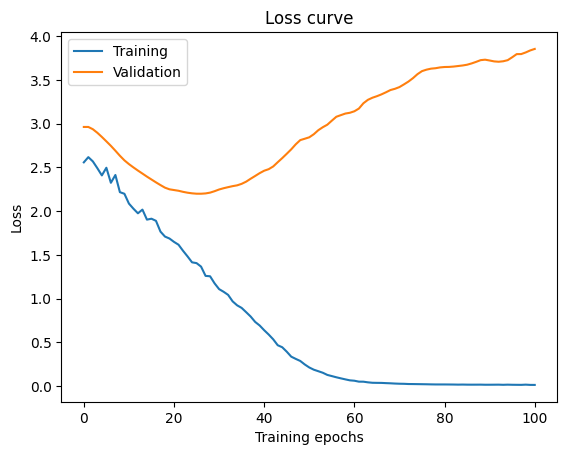

In [14]:
fig, ax = plt.subplots()
ax.plot(train_losses, label="Training")
ax.plot(val_losses, label="Validation")
ax.set_title("Loss curve")
ax.set_xlabel("Training epochs")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

In [ ]:
# n_epochs = 10

# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

# train_losses, valid_losses = [], []

# for e in range(epochs):
#     model = train(train_dataset, valid_dataset, model, tokenizer)
    
#     train_loss, detokenized_outputs_train = \
#     evaluate(model, train_dataloader, device=torch.device("cuda"), output_file='detokenized_outputs_train.txt', tokenizer=tokenizer)
#     train_losses.append(train_loss)
    
#     valid_loss, detokenized_outputs_valid = \
#     evaluate(model, valid_dataloader, device=torch.device("cuda"), output_file=output_file, tokenizer=tokenizer)
#     valid_losses.append(valid_loss)

### Fixing evaluate()

In [9]:
# Define your GPT-2 model and tokenizer
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# model = GPT2LMHeadModel.from_pretrained('gpt2')

# # Specify the dataset name and file path
# dataset_name = "propmts_and_completions"
# file_path = 'prompts.json'
# output_file = 'detokenized_outputs.txt'

# # Prepare the dataset
# train_dataset, val_dataset, test_dataset = prepare_dataset(dataset_name, file_path, tokenizer)

In [15]:
# # Evaluate on the validation set
# val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
# val_loss, detokenized_outputs = evaluate(model, val_dataloader, device=torch.device("cuda"), output_file=output_file, tokenizer=tokenizer)
# print(f"Validation Loss: {val_loss}")

# # Evaluate on the test set
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
# test_loss, detokenized_outputs_test = evaluate(model, test_dataloader, device=torch.device("cuda"), output_file='detokenized_outputs_test.txt', tokenizer=tokenizer)
# print(f"Test Loss: {test_loss}")